![header](../figures/logos_partenaires._cmems_se.jpg)

# Benchmark MIOST sea surface height maps (Geostrophic mode only)

<div style="text-align: right"><i> 2023-04-27 MIOST_SSH_GEOS_BENCHMARK_DEMO </i></div>

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark of MIOST sea surface height maps</center></h1>
<h5> The notebook aims to evaluate the sea surface height maps produced by the MIOST system. </h5>
    <h5> These maps are equivalent to the SEALEVEL_GLO_PHY_L4_MY_008_047 product distributed by the Copernicus Marine Service, except that a nadir altimeter (SARAL/Altika, SEALEVEL_GLO_PHY_L3_MY_008_062 product) has been excluded from the mapping. </h5>
        <h5> We provide below a demonstration of the validation of these maps against the independent SSH data from the Saral/AltiKa altimeter distributed by CMEMS </h5>
</div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can evaluated sea surface height maps with independent alongtrack data: statistical and spectral analysis</li>
</ul>
    
</div>

In [1]:
from glob import glob
import numpy as np
import os
import sys 

In [2]:
sys.path.append('../')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [4]:
time_min = '2017-01-01'                                        # time min for analysis
time_max = '2017-12-31'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')

box_lonlat = {'lon_min':-6,
              'lon_max':36,
              'lat_min':30,
              'lat_max':46 }

method_name = 'miost'

stat_output_filename = f'{output_dir}/stat_sla_'+method_name+'.nc'  # output statistical analysis filename
lambda_min = 65.                                               # minimun spatial scale in kilometer to consider on the filtered signal
lambda_max = 500.                                              # maximum spatial scale in kilometer to consider on the filtered signal
psd_output_filename = f'{output_dir}/psd_sla_'+method_name+'.nc'    # output spectral analysis filename
segment_lenght = 500.                                         # spectral parameer: along-track segment lenght in kilometer to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## Sea Surface Height from Saral/AltiKa

In [5]:
list_of_file = sorted(glob('../data/eval/indep_nadirs/*.nc'))
ds_h2a = xr.open_mfdataset(list_of_file, combine='nested', concat_dim='time')
ds_h2a = ds_h2a.where((ds_h2a.time >= np.datetime64(time_min)) & (ds_h2a.time <=  np.datetime64(time_max)), drop=True)
ds_h2a = ds_h2a.sortby('time')
ds_h2a

<xarray.Dataset>
Dimensions:         (time: 878653)
Coordinates:
  * time            (time) datetime64[ns] 2017-01-01T09:50:52.500000 ... 2017...
    longitude       (time) float64 dask.array<chunksize=(1289,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(1289,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(1289,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(1289,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(1289,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(1289,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(1289,), meta=np.ndarray>
    ocean_tide      (time) float32 dask.array<chunksize=(1289,), meta=np.ndarray>
    internal_tide   (time) float32 dask.array<chunksize=(1289,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(1289,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(1289,), meta=np.ndarray>
    tpa_correction  (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P10H7M39.600000S
    time_coverage_end:               2017-01-01T19:58:32Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2017-01-01T09:50:52Z
    title:                           DT Haiyang-2A Geodetic Phase European Se...

## Sea Surface Height maps to evaluate

In [6]:
list_of_maps = sorted(glob('../data/maps/MIOST/*.nc'))
ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
ds_maps = ds_maps.sel(time=slice(time_min, time_max))
ds_maps

<xarray.Dataset>
Dimensions:             (longitude: 1012, latitude: 378, time: 365)
Coordinates:
  * longitude           (longitude) float32 -6.062 -6.021 -5.979 ... 36.02 36.06
  * latitude            (latitude) float32 30.27 30.31 30.35 ... 45.94 45.98
  * time                (time) datetime64[ns] 2017-01-01 ... 2017-12-31
Data variables:
    sla                 (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    ugosa               (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    vgosa               (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    relative_vorticity  (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    adt                 (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    ugos                (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    vgos                (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface height maps onto along-track positions

In [7]:
ds_interp = run_interpolation(ds_maps, ds_h2a)
ds_interp = ds_interp.dropna('time')
ds_interp

2023-12-04 14:51:57 INFO     fetch data from 2017-01-01 00:00:00 to 2017-02-01 00:00:00
2023-12-04 14:51:58 INFO     fetch data from 2017-01-31 00:00:00 to 2017-03-01 00:00:00
2023-12-04 14:51:59 INFO     fetch data from 2017-02-28 00:00:00 to 2017-04-01 00:00:00
2023-12-04 14:52:00 INFO     fetch data from 2017-03-31 00:00:00 to 2017-05-01 00:00:00
2023-12-04 14:52:01 INFO     fetch data from 2017-04-30 00:00:00 to 2017-06-01 00:00:00
2023-12-04 14:52:02 INFO     fetch data from 2017-05-31 00:00:00 to 2017-07-01 00:00:00
2023-12-04 14:52:02 INFO     fetch data from 2017-06-30 00:00:00 to 2017-08-01 00:00:00
2023-12-04 14:52:03 INFO     fetch data from 2017-07-31 00:00:00 to 2017-09-01 00:00:00
2023-12-04 14:52:04 INFO     fetch data from 2017-08-31 00:00:00 to 2017-10-01 00:00:00
2023-12-04 14:52:05 INFO     fetch data from 2017-09-30 00:00:00 to 2017-11-01 00:00:00
2023-12-04 14:52:06 INFO     fetch data from 2017-10-31 00:00:00 to 2017-12-01 00:00:00
2023-12-04 14:52:07 INFO     fet

<xarray.Dataset>
Dimensions:            (time: 120190)
Coordinates:
  * time               (time) datetime64[ns] 2017-01-01T16:25:49.500000 ... 2...
Data variables: (12/13)
    cycle              (time) float64 149.0 149.0 149.0 ... 189.0 189.0 189.0
    track              (time) float64 129.0 129.0 129.0 ... 215.0 215.0 215.0
    sla_unfiltered     (time) float32 0.042 -0.053 -0.043 ... 0.068 -0.004 0.023
    sla_filtered       (time) float32 -0.008 -0.022 -0.025 ... 0.047 0.042 0.031
    dac                (time) float32 -0.157 -0.157 -0.157 ... -0.108 -0.107
    ocean_tide         (time) float32 0.024 0.023 0.023 ... -0.25 -0.249 -0.247
    ...                 ...
    lwe                (time) float32 -0.036 -0.035 -0.034 ... -0.045 -0.045
    mdt                (time) float32 -0.002 -0.006 -0.011 ... -0.014 -0.011
    tpa_correction     (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude          (time) float64 21.4 21.38 21.36 ... 355.6 355.6 355.5
    latitude           (time) float64 32.91 32.97 33.03 ... 36.39 36.45 36.5
    msla_interpolated  (time) float64 0.04174 0.04003 0.03923 ... 0.0349 0.03322

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

In [8]:
compute_stat_scores(ds_interp, lambda_min, lambda_max, stat_output_filename, method_name)

2023-12-04 14:52:08 INFO     Compute mapping error all scales
2023-12-04 14:52:08 INFO     Compute mapping error for scales between 65.0 and 500.0 km


Total RMSE= 0.04599875114208964 m
Total RMSE score= 0.5534420657720187 m


2023-12-04 14:52:08 INFO     Compute binning statistics
2023-12-04 14:52:11 INFO     Compute statistics by oceanic regime
2023-12-04 14:52:32 INFO     Stat file saved as: ../results/stat_sla_miost.nc


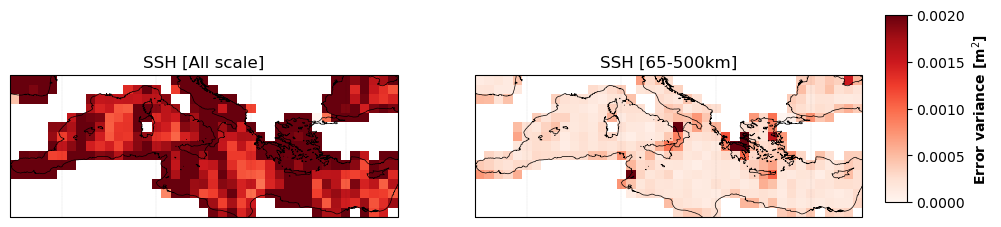

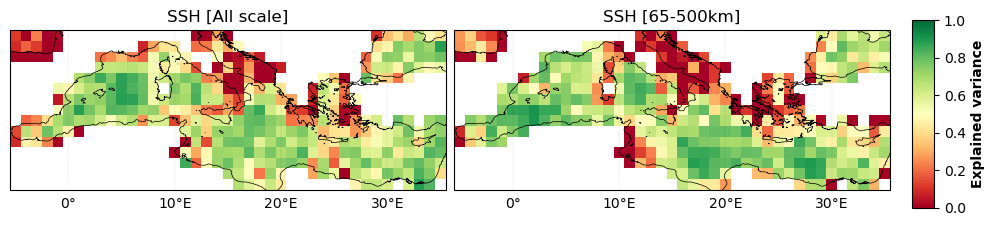

In [9]:
# Plot gridded stats 
plot_stat_score_map_png(stat_output_filename,region='4DMedSea',box_lonlat=box_lonlat)

## 2.3 Compute Spectral scores

In [10]:
compute_psd_scores_v2(ds_interp, psd_output_filename, lenght_scale=segment_lenght, method_name=method_name)

2023-12-04 14:52:37 INFO     Segment computation...
2023-12-04 14:52:37 INFO     Spectral analysis...
2023-12-04 14:52:42 INFO     Saving ouput...
2023-12-04 14:52:44 INFO     PSD file saved as: ../results/psd_sla_miost.nc


Averaged effective resolution: 121.2739142640078 km


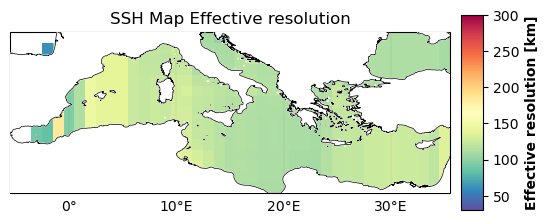

In [11]:
# Plot effective resolution 
plot_effective_resolution_png(psd_output_filename,region='4DMedSea',box_lonlat=box_lonlat, max_resol=300)